In [97]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
import seaborn as sns
import numpy as np
import pandas as pd

In [123]:

d = pd.read_excel('/Users/cameronrichardson/Documents/Thesis/Experiments/data/processedData.xlsx', sheet_name='export')

# # Define ion list and fixed color mapping for authors
ions = ['Ca', 'Mg', 'SO4']
temp = [10, 20, 30]


# Filter out rows with NaN values in 'Conc Multiplier' or 'pK1'
# filtered_data = d.dropna(subset=['Conc Multiplier', 'pK1', 'pK2'])

filtered_data = d
# Get unique temperatures
unique_temperatures = filtered_data['Temperature'].unique()

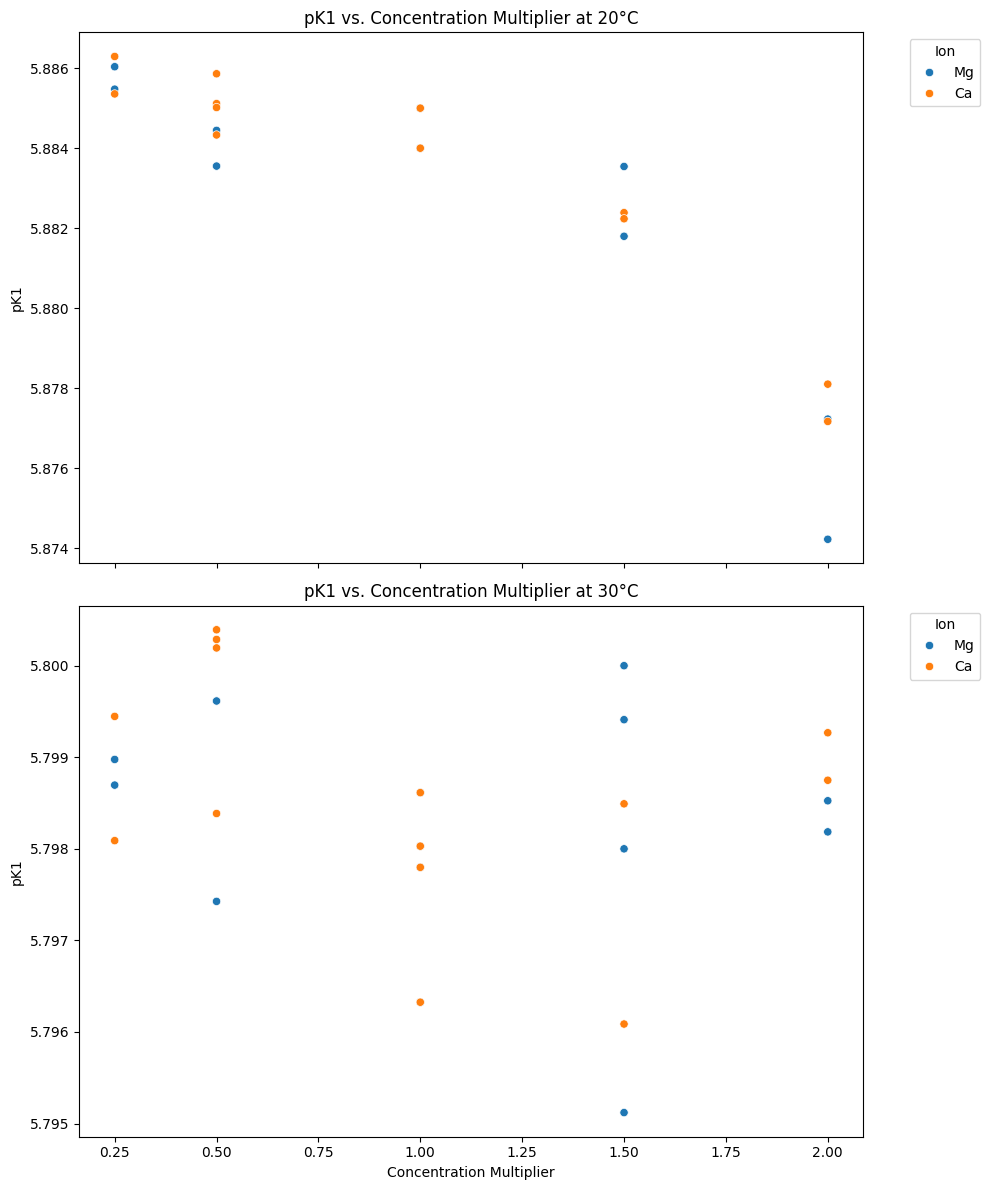

In [124]:



# Create subplots for each temperature
fig, axs = plt.subplots(len(unique_temperatures), 1, figsize=(10, 6 * len(unique_temperatures)), sharex=True)

# Ensure axs is iterable if there's only one temperature
if len(unique_temperatures) == 1:
    axs = [axs]

# Plot data for each temperature
for ax, temp in zip(axs, unique_temperatures):
    temp_data = filtered_data[filtered_data['Temperature'] == temp]
    sns.scatterplot(
        data=temp_data,
        x='Conc Multiplier',
        y='pK1',
        hue='Ion',
        palette='tab10',
        ax=ax
    )
    ax.set_title(f'pK1 vs. Concentration Multiplier at {temp}°C')
    ax.set_xlabel('Concentration Multiplier')
    ax.set_ylabel('pK1')
    ax.legend(title='Ion', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

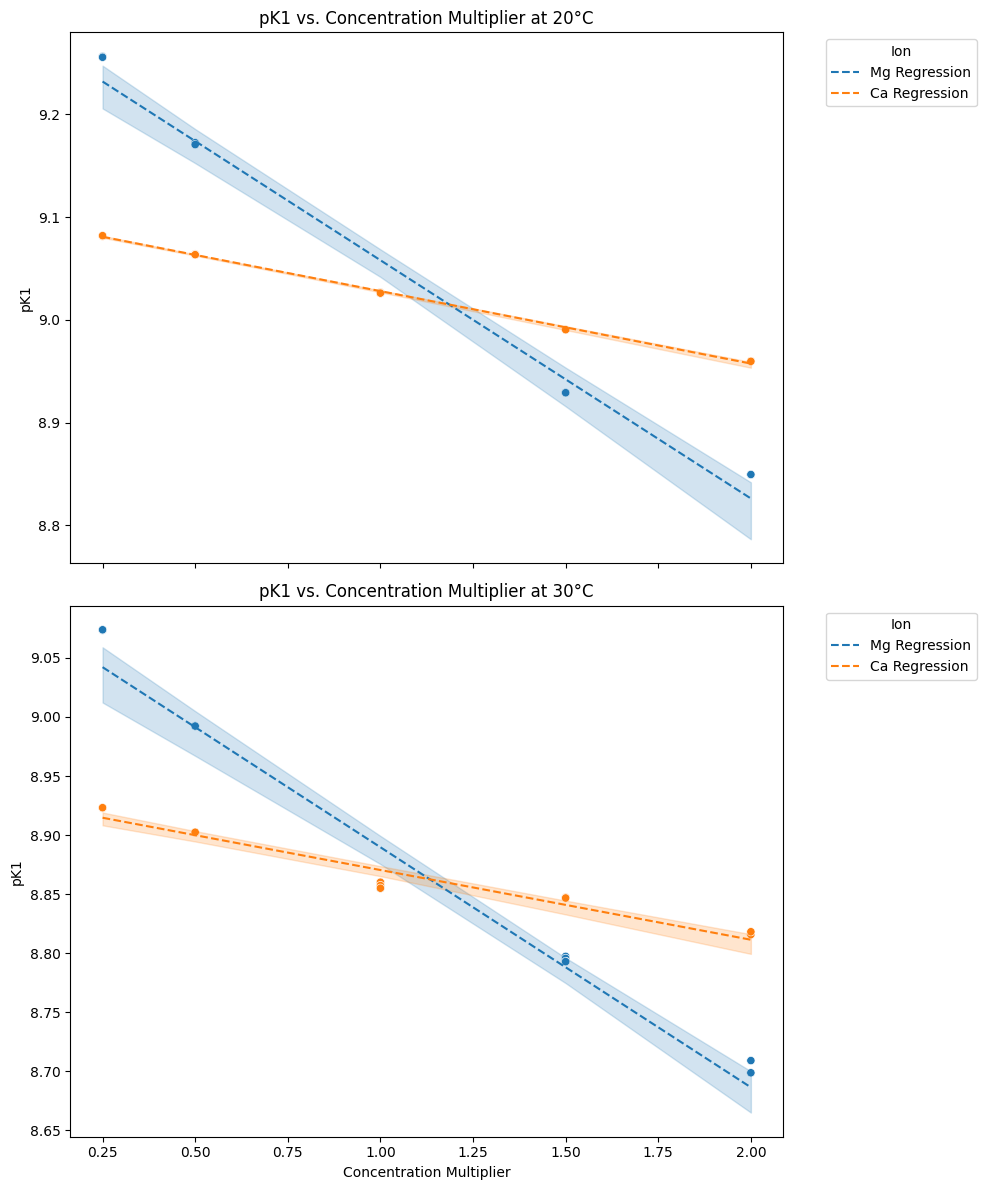

In [128]:


# Set the color palette and store it for consistent use
unique_ions = filtered_data['Ion'].unique()
palette = sns.color_palette('tab10', len(unique_ions))
ion_colors = dict(zip(unique_ions, palette))

# Create subplots for each temperature
fig, axs = plt.subplots(len(unique_temperatures), 1, figsize=(10, 6 * len(unique_temperatures)), sharex=True)
if len(unique_temperatures) == 1:
    axs = [axs]

# Plotting
for ax, temp in zip(axs, unique_temperatures):
    temp_data = filtered_data[filtered_data['Temperature'] == temp]

    # Scatter plot
    sns.scatterplot(
        data=temp_data,
        x='Conc Multiplier',
        y='pK2',
        hue='Ion',
        palette=ion_colors,
        ax=ax,
        legend=False  # We'll build a custom legend manually
    )

    # Regression + bootstrap CI per ion
    for ion in temp_data['Ion'].unique():
        ion_data = temp_data[temp_data['Ion'] == ion]
        X = ion_data['Conc Multiplier'].values.reshape(-1, 1)
        y = ion_data['pK2'].values

        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)

        # Plot regression line
        ax.plot(X, y_pred, linestyle='--', label=f'{ion} Regression', color=ion_colors[ion])

        # Bootstrap CI
        n_bootstraps = 10000
        boot_preds = []
        for _ in range(n_bootstraps):
            X_resampled, y_resampled = resample(X, y)
            model.fit(X_resampled, y_resampled)
            boot_preds.append(model.predict(X))

        boot_preds = np.array(boot_preds)
        lower_bound = np.percentile(boot_preds, 5, axis=0)
        upper_bound = np.percentile(boot_preds, 95, axis=0)

        ax.fill_between(
            X.flatten(),
            lower_bound,
            upper_bound,
            color=ion_colors[ion],
            alpha=0.2
        )

    ax.set_title(f'pK1 vs. Concentration Multiplier at {temp}°C')
    ax.set_xlabel('Concentration Multiplier')
    ax.set_ylabel('pK1')
    ax.legend(title='Ion', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


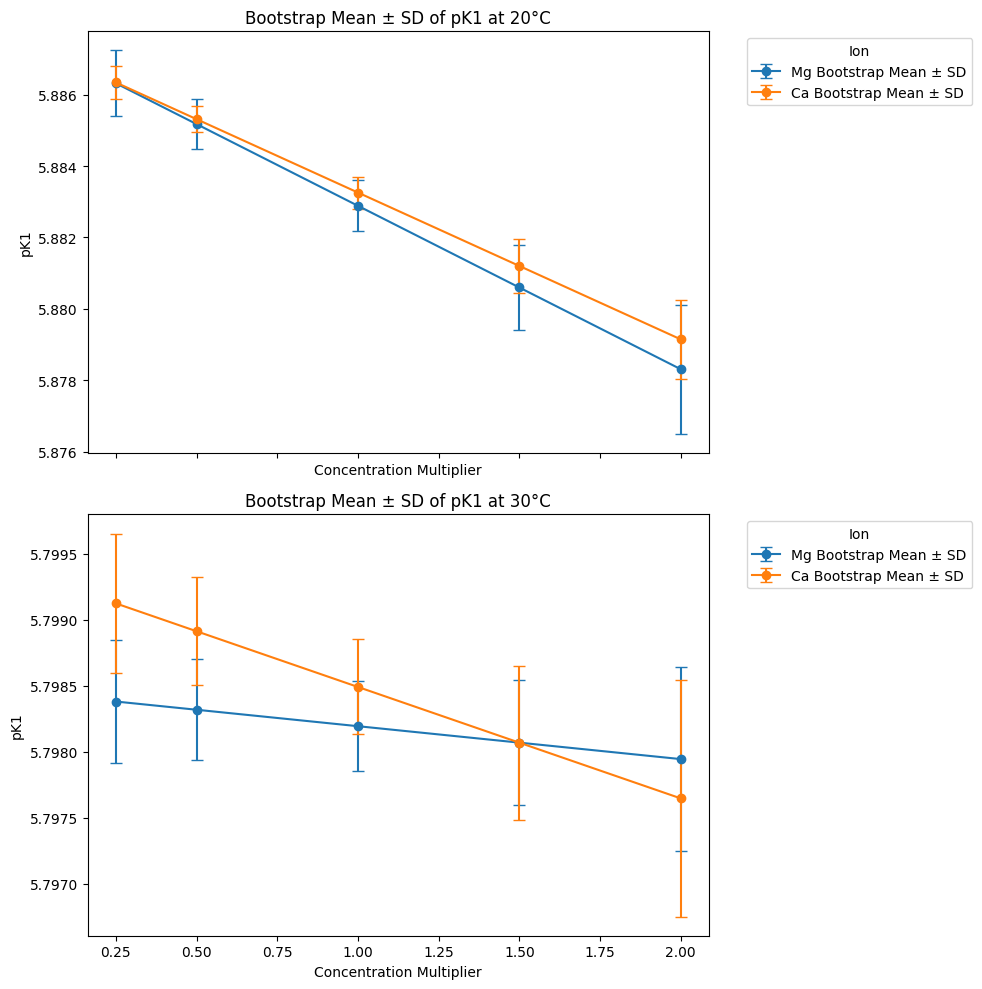

In [100]:
# Unique concentration multipliers
conc_values = np.sort(filtered_data['Conc Multiplier'].unique())

# Start plotting
fig, axs = plt.subplots(len(unique_temperatures), 1, figsize=(10, 5 * len(unique_temperatures)), sharex=True)
if len(unique_temperatures) == 1:
    axs = [axs]

for ax, temp in zip(axs, unique_temperatures):
    temp_data = filtered_data[filtered_data['Temperature'] == temp]

    for ion in temp_data['Ion'].unique():
        ion_data = temp_data[temp_data['Ion'] == ion]

        X_raw = ion_data['Conc Multiplier'].values.reshape(-1, 1)
        y_raw = ion_data['pK1'].values

        # Prepare for bootstrapping
        n_bootstraps = 1000
        model = LinearRegression()

        # Create prediction matrix at all unique X points
        all_preds = {x_val: [] for x_val in conc_values}

        for _ in range(n_bootstraps):
            X_resampled, y_resampled = resample(X_raw, y_raw)
            model.fit(X_resampled, y_resampled)
            for x_val in conc_values:
                pred = model.predict(np.array([[x_val]]))[0]
                all_preds[x_val].append(pred)

        # Convert to mean ± std for error bars
        means = [np.mean(all_preds[x]) for x in conc_values]
        stds = [np.std(all_preds[x]) for x in conc_values]

        ax.errorbar(
            conc_values,
            means,
            yerr=stds,
            fmt='o-',
            capsize=4,
            label=f'{ion} Bootstrap Mean ± SD',
            color=ion_colors[ion]
        )

    ax.set_title(f'Bootstrap Mean ± SD of pK1 at {temp}°C')
    ax.set_xlabel('Concentration Multiplier')
    ax.set_ylabel('pK1')
    ax.legend(title='Ion', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


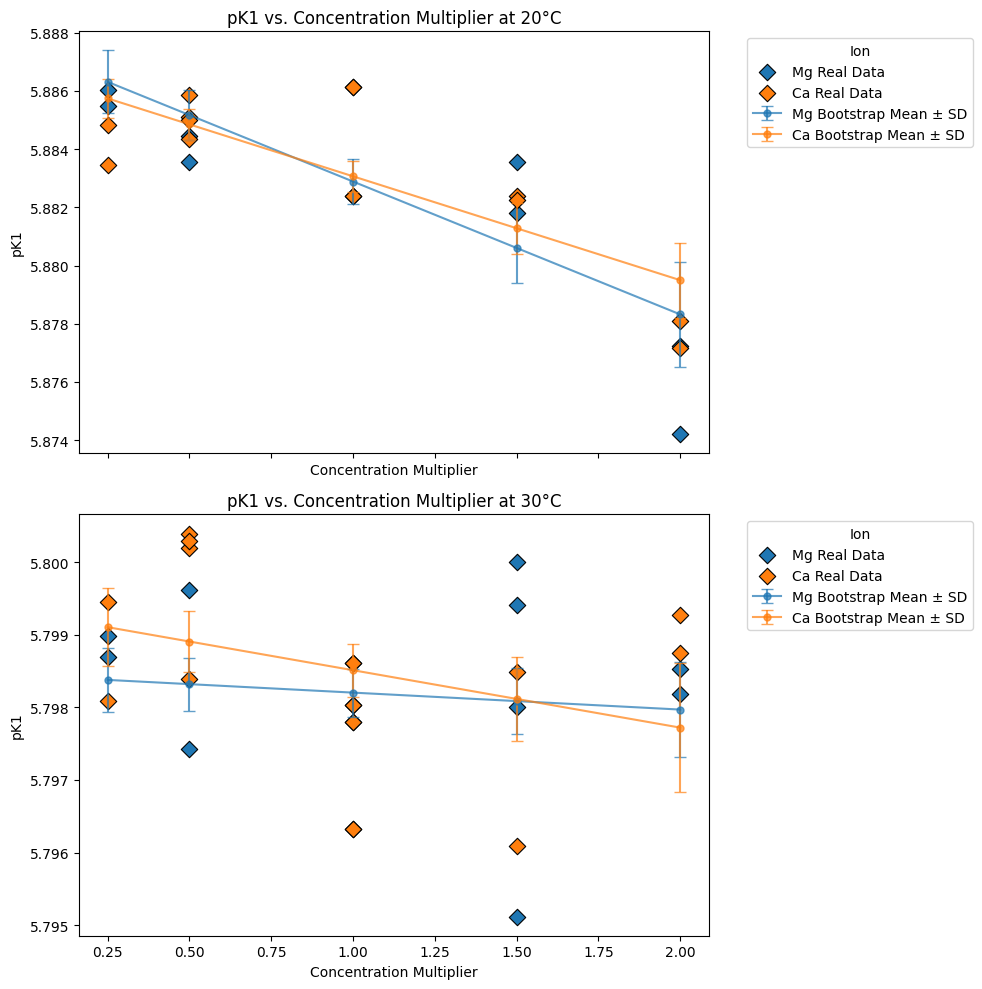

In [89]:
fig, axs = plt.subplots(len(unique_temperatures), 1, figsize=(10, 5 * len(unique_temperatures)), sharex=True)
if len(unique_temperatures) == 1:
    axs = [axs]

for ax, temp in zip(axs, unique_temperatures):
    temp_data = filtered_data[filtered_data['Temperature'] == temp]

    for ion in temp_data['Ion'].unique():
        ion_data = temp_data[temp_data['Ion'] == ion]
        X_raw = ion_data['Conc Multiplier'].values.reshape(-1, 1)
        y_raw = ion_data['pK1'].values

        # Unique X values for prediction
        conc_values = np.sort(ion_data['Conc Multiplier'].unique())
        n_bootstraps = 1000
        model = LinearRegression()
        all_preds = {x_val: [] for x_val in conc_values}

        # Bootstrap
        for _ in range(n_bootstraps):
            X_resampled, y_resampled = resample(X_raw, y_raw)
            model.fit(X_resampled, y_resampled)
            for x_val in conc_values:
                pred = model.predict(np.array([[x_val]]))[0]
                all_preds[x_val].append(pred)

        # Mean and std dev of predictions
        means = [np.mean(all_preds[x]) for x in conc_values]
        stds = [np.std(all_preds[x]) for x in conc_values]

        # Plot bootstrapped mean ± SD
        ax.errorbar(
            conc_values,
            means,
            yerr=stds,
            fmt='o-',
            capsize=4,
            label=f'{ion} Bootstrap Mean ± SD',
            color=ion_colors[ion],
            markersize=5,
            alpha=0.7
        )

        # Overlay real data
        ax.scatter(
            X_raw.flatten(),
            y_raw,
            color=ion_colors[ion],
            s=70,
            edgecolor='black',
            linewidth=0.8,
            marker='D',  # diamond for contrast
            label=f'{ion} Real Data'
        )

    ax.set_title(f'pK1 vs. Concentration Multiplier at {temp}°C')
    ax.set_xlabel('Concentration Multiplier')
    ax.set_ylabel('pK1')
    ax.legend(title='Ion', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


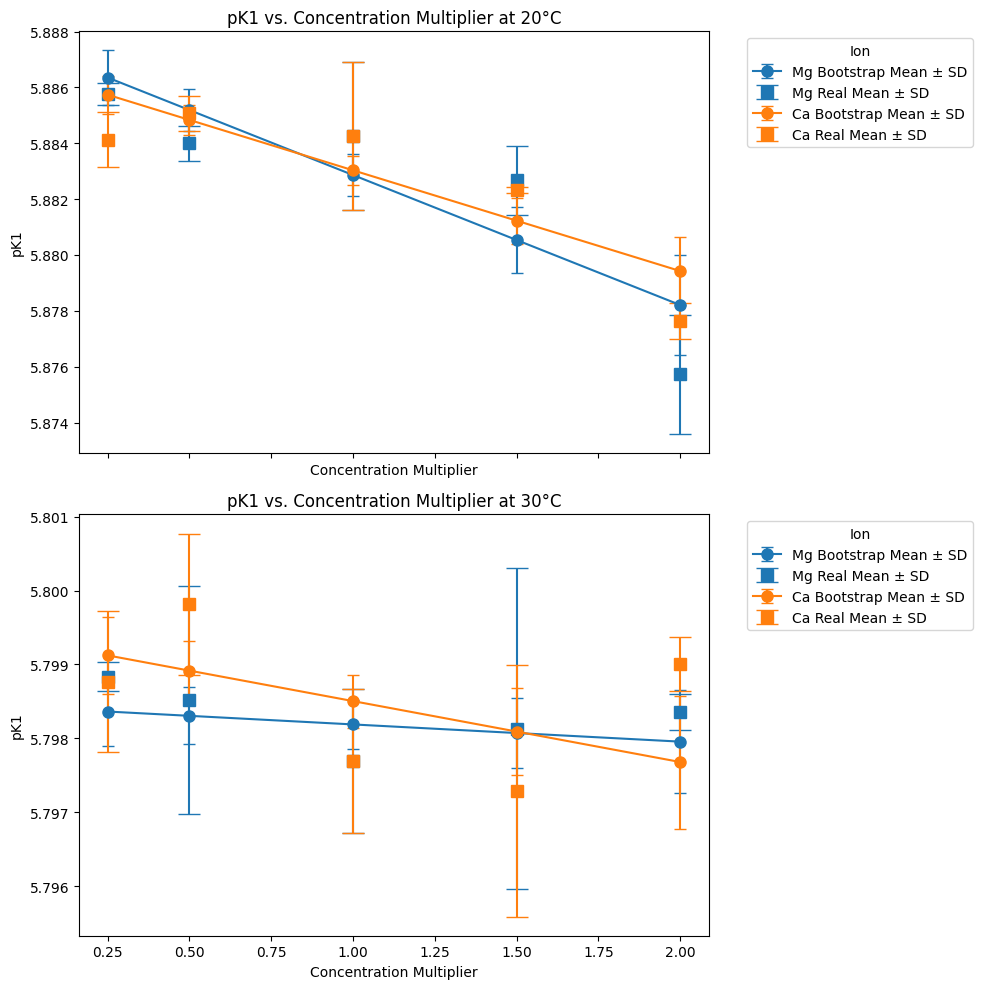

In [92]:
fig, axs = plt.subplots(len(unique_temperatures), 1, figsize=(10, 5 * len(unique_temperatures)), sharex=True)
if len(unique_temperatures) == 1:
    axs = [axs]

for ax, temp in zip(axs, unique_temperatures):
    temp_data = filtered_data[filtered_data['Temperature'] == temp]

    for ion in temp_data['Ion'].unique():
        ion_data = temp_data[temp_data['Ion'] == ion]
        X_raw = ion_data['Conc Multiplier'].values.reshape(-1, 1)
        y_raw = ion_data['pK1'].values

        # Unique Conc Multipliers
        conc_values = np.sort(ion_data['Conc Multiplier'].unique())
        n_bootstraps = 10000
        model = LinearRegression()
        all_preds = {x_val: [] for x_val in conc_values}

        # Bootstrap predictions
        for _ in range(n_bootstraps):
            X_resampled, y_resampled = resample(X_raw, y_raw)
            model.fit(X_resampled, y_resampled)
            for x_val in conc_values:
                pred = model.predict(np.array([[x_val]]))[0]
                all_preds[x_val].append(pred)

        # Mean and std dev of bootstrapped predictions
        boot_means = [np.mean(all_preds[x]) for x in conc_values]
        boot_stds = [np.std(all_preds[x]) for x in conc_values]

        # Plot bootstrap regression + CI
        ax.errorbar(
            conc_values,
            boot_means,
            yerr=boot_stds,
            fmt='o-',
            capsize=4,
            label=f'{ion} Bootstrap Mean ± SD',
            color=ion_colors[ion],
            markersize=8
        )

        # Now calculate and plot real data means ± SD at each concentration
        real_means = []
        real_stds = []
        for conc in conc_values:
            pk_vals = ion_data[ion_data['Conc Multiplier'] == conc]['pK1']
            real_means.append(pk_vals.mean())
            real_stds.append(pk_vals.std(ddof=1) if len(pk_vals) > 1 else 0)

        # Plot mean ± SD of real data
        ax.errorbar(
            conc_values,
            real_means,
            yerr=real_stds,
            fmt='s',
            capsize=8,
            markersize=8,
            color=ion_colors[ion],
            linestyle='none',
            label=f'{ion} Real Mean ± SD',
        )

    ax.set_title(f'pK1 vs. Concentration Multiplier at {temp}°C')
    ax.set_xlabel('Concentration Multiplier')
    ax.set_ylabel('pK1')
    ax.legend(title='Ion', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


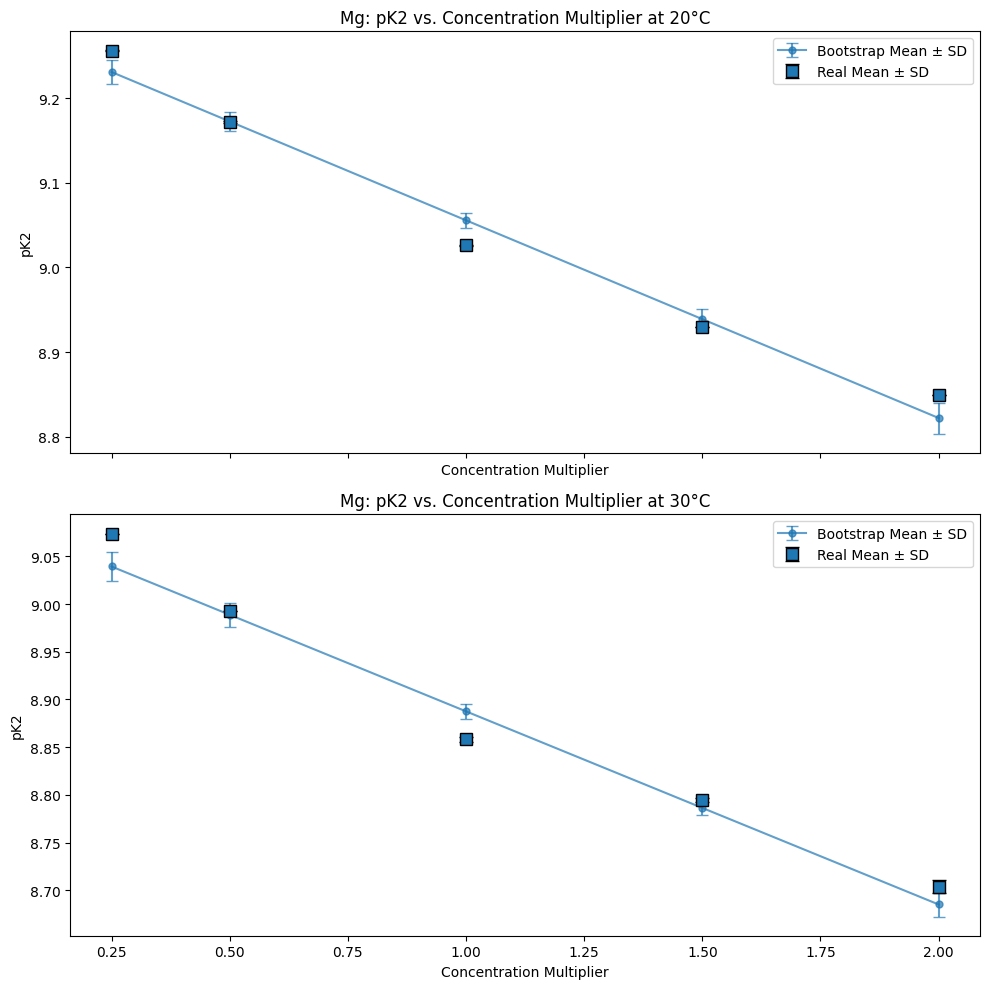

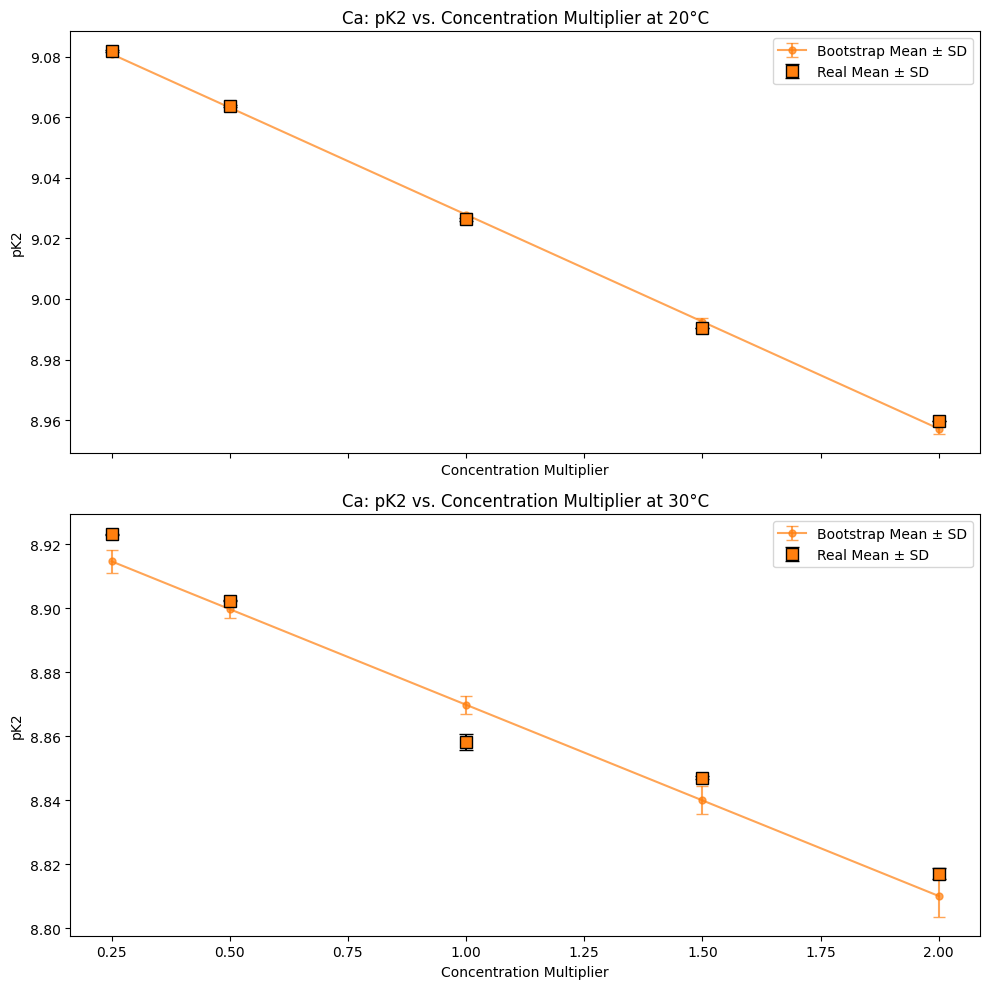

In [131]:
unique_ions = filtered_data['Ion'].unique()
palette = sns.color_palette('tab10', len(unique_ions))
ion_colors = dict(zip(unique_ions, palette))

# Loop over each Ion
for ion in unique_ions:
    ion_data_all = filtered_data[filtered_data['Ion'] == ion]
    unique_temperatures = sorted(ion_data_all['Temperature'].unique())

    # Set up subplots for temperatures
    fig, axs = plt.subplots(len(unique_temperatures), 1, figsize=(10, 5 * len(unique_temperatures)), sharex=True)
    if len(unique_temperatures) == 1:
        axs = [axs]

    for ax, temp in zip(axs, unique_temperatures):
        temp_data = ion_data_all[ion_data_all['Temperature'] == temp]

        X_raw = temp_data['Conc Multiplier'].values.reshape(-1, 1)
        y_raw = temp_data['pK2'].values
        conc_values = np.sort(temp_data['Conc Multiplier'].unique())

        # Bootstrap predictions
        n_bootstraps = 1000
        model = LinearRegression()
        all_preds = {x_val: [] for x_val in conc_values}

        for _ in range(n_bootstraps):
            X_resampled, y_resampled = resample(X_raw, y_raw)
            model.fit(X_resampled, y_resampled)
            for x_val in conc_values:
                pred = model.predict(np.array([[x_val]]))[0]
                all_preds[x_val].append(pred)

        # Compute bootstrap mean ± std
        boot_means = [np.mean(all_preds[x]) for x in conc_values]
        boot_stds = [np.std(all_preds[x]) for x in conc_values]

        # Plot bootstrap means ± SD
        ax.errorbar(
            conc_values,
            boot_means,
            yerr=boot_stds,
            fmt='o-',
            capsize=4,
            label=f'Bootstrap Mean ± SD',
            color=ion_colors[ion],
            markersize=5,
            alpha=0.7
        )

        # Real data mean ± SD
        real_means = []
        real_stds = []
        for conc in conc_values:
            pk_vals = temp_data[temp_data['Conc Multiplier'] == conc]['pK2']
            real_means.append(pk_vals.mean())
            real_stds.append(pk_vals.std(ddof=1) if len(pk_vals) > 1 else 0)

        ax.errorbar(
            conc_values,
            real_means,
            yerr=real_stds,
            fmt='s',
            capsize=5,
            markersize=8,
            color=ion_colors[ion],
            ecolor='black',
            markeredgecolor='black',
            linestyle='none',
            label='Real Mean ± SD'
        )

        ax.set_title(f'{ion}: pK2 vs. Concentration Multiplier at {temp}°C')
        ax.set_xlabel('Concentration Multiplier')
        ax.set_ylabel('pK2')
        ax.legend(loc='best')

    plt.tight_layout()
    plt.show()



Ion: Mg | Temperature: 20°C
Real Data Regression:
  Slope: -0.231737, Intercept: 9.289732, R²: 0.979543, p-value: 0.000000, SE: 0.011840
Bootstrap Mean Regression:
  Slope: -0.232817, Intercept: 9.288614, R²: 1.000000, p-value: 0.000000, SE: 0.000000

Ion: Mg | Temperature: 30°C
Real Data Regression:
  Slope: -0.203249, Intercept: 9.092992, R²: 0.964109, p-value: 0.000000, SE: 0.011321
Bootstrap Mean Regression:
  Slope: -0.202087, Intercept: 9.089868, R²: 1.000000, p-value: 0.000000, SE: 0.000000


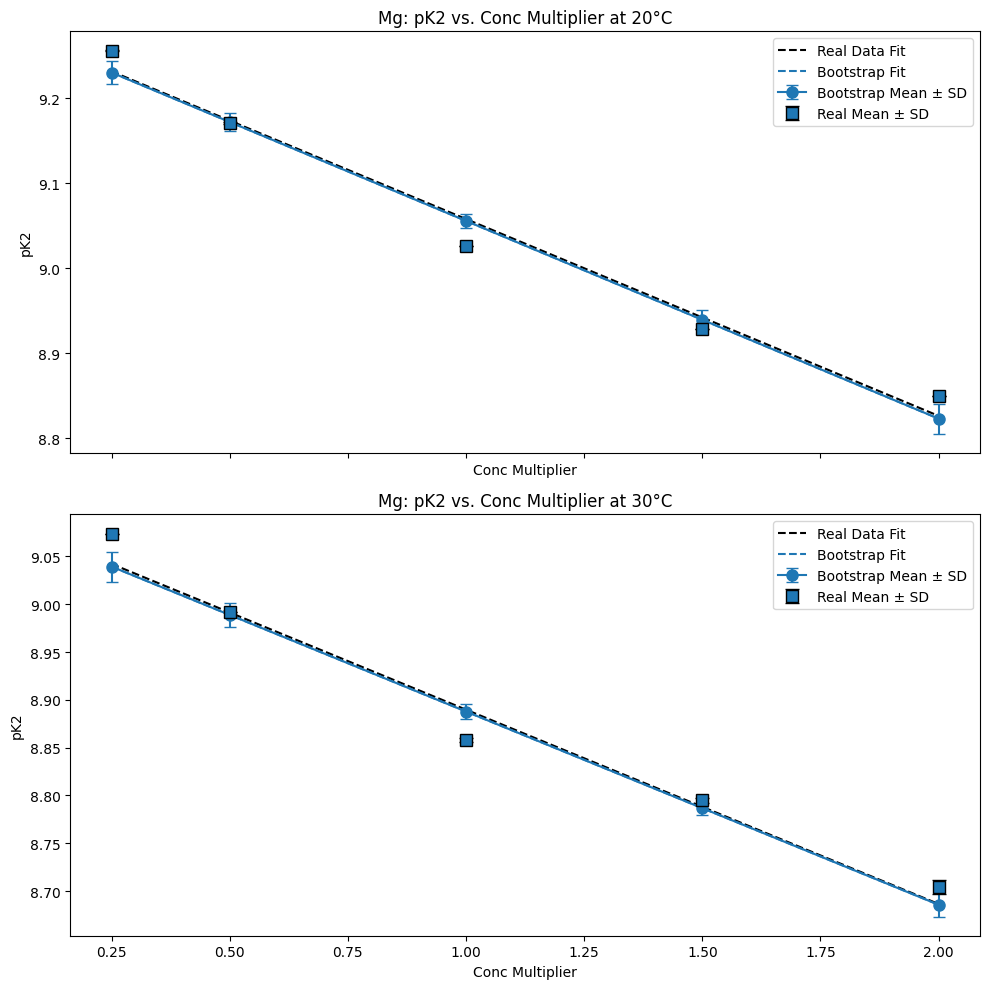


Ion: Ca | Temperature: 20°C
Real Data Regression:
  Slope: -0.070468, Intercept: 9.098410, R²: 0.998716, p-value: 0.000000, SE: 0.000799
Bootstrap Mean Regression:
  Slope: -0.070680, Intercept: 9.098520, R²: 1.000000, p-value: 0.000000, SE: 0.000000

Ion: Ca | Temperature: 30°C
Real Data Regression:
  Slope: -0.059011, Intercept: 8.929463, R²: 0.945299, p-value: 0.000000, SE: 0.004098
Bootstrap Mean Regression:
  Slope: -0.059533, Intercept: 8.929650, R²: 1.000000, p-value: 0.000000, SE: 0.000000


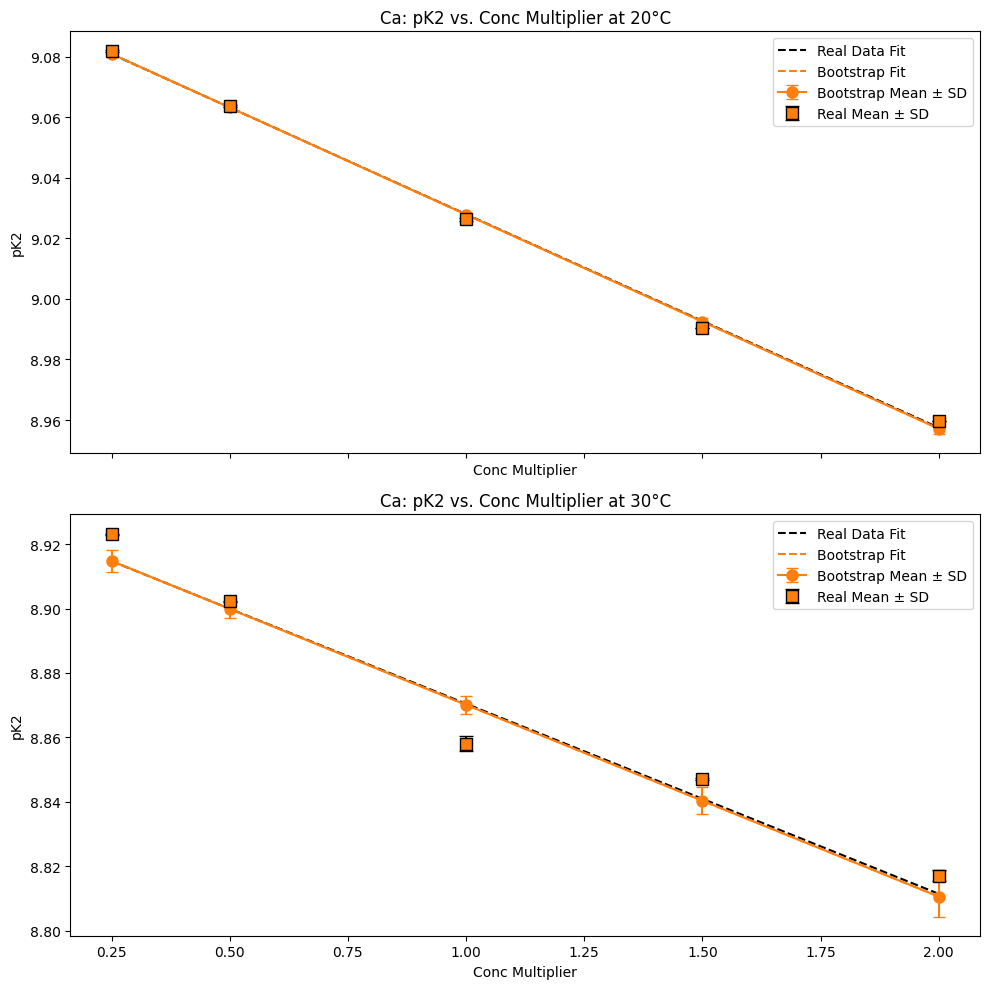

In [133]:
from scipy.stats import linregress

for ion in unique_ions:
    ion_data_all = filtered_data[filtered_data['Ion'] == ion]
    unique_temperatures = sorted(ion_data_all['Temperature'].unique())

    fig, axs = plt.subplots(len(unique_temperatures), 1, figsize=(10, 5 * len(unique_temperatures)), sharex=True)
    if len(unique_temperatures) == 1:
        axs = [axs]

    for ax, temp in zip(axs, unique_temperatures):
        temp_data = ion_data_all[ion_data_all['Temperature'] == temp]

        X_raw = temp_data['Conc Multiplier'].values
        y_raw = temp_data['pK2'].values
        X_raw_2D = X_raw.reshape(-1, 1)
        conc_values = np.sort(temp_data['Conc Multiplier'].unique())

        # ----- Bootstrap regression -----
        n_bootstraps = 1000
        model = LinearRegression()
        all_preds = {x_val: [] for x_val in conc_values}

        for _ in range(n_bootstraps):
            X_resampled, y_resampled = resample(X_raw_2D, y_raw)
            model.fit(X_resampled, y_resampled)
            for x_val in conc_values:
                pred = model.predict(np.array([[x_val]]))[0]
                all_preds[x_val].append(pred)

        boot_means = np.array([np.mean(all_preds[x]) for x in conc_values])
        boot_stds = np.array([np.std(all_preds[x]) for x in conc_values])

        # Fit regression to bootstrap means
        slope_boot, intercept_boot, r_boot, p_boot, stderr_boot = linregress(conc_values, boot_means)

        # ----- Real regression -----
        slope_real, intercept_real, r_real, p_real, stderr_real = linregress(X_raw, y_raw)

        # Print comparison
        print(f"\nIon: {ion} | Temperature: {temp}°C")
        print("Real Data Regression:")
        print(f"  Slope: {slope_real:.6f}, Intercept: {intercept_real:.6f}, R²: {r_real**2:.6f}, p-value: {p_real:.6f}, SE: {stderr_real:.6f}")
        print("Bootstrap Mean Regression:")
        print(f"  Slope: {slope_boot:.6f}, Intercept: {intercept_boot:.6f}, R²: {r_boot**2:.6f}, p-value: {p_boot:.6f}, SE: {stderr_boot:.6f}")

        # ----- Plotting -----
        # Plot bootstrap mean ± SD
        ax.errorbar(
            conc_values, boot_means, yerr=boot_stds,
            fmt='o-', capsize=4, markersize=8, color=ion_colors[ion],
            alpha=1, label='Bootstrap Mean ± SD'
        )

        # Plot real data points (means)
        real_means = []
        real_stds = []
        for x in conc_values:
            pk = temp_data[temp_data['Conc Multiplier'] == x]['pK2']
            real_means.append(pk.mean())
            real_stds.append(pk.std(ddof=1) if len(pk) > 1 else 0)

        ax.errorbar(
            conc_values, real_means, yerr=real_stds,
            fmt='s', capsize=5, markersize=8,
            color=ion_colors[ion], ecolor='black',
            markeredgecolor='black', linestyle='none',
            label='Real Mean ± SD'
        )

        # Regression lines (real vs bootstrap)
        x_fit = np.linspace(min(conc_values), max(conc_values), 100)
        y_fit_real = intercept_real + slope_real * x_fit
        y_fit_boot = intercept_boot + slope_boot * x_fit

        ax.plot(x_fit, y_fit_real, '--', color='black', label='Real Data Fit')
        ax.plot(x_fit, y_fit_boot, '--', color=ion_colors[ion], label='Bootstrap Fit')

        ax.set_title(f'{ion}: pK2 vs. Conc Multiplier at {temp}°C')
        ax.set_xlabel('Conc Multiplier')
        ax.set_ylabel('pK2')
        ax.legend(loc='best')

    plt.tight_layout()
    plt.show()


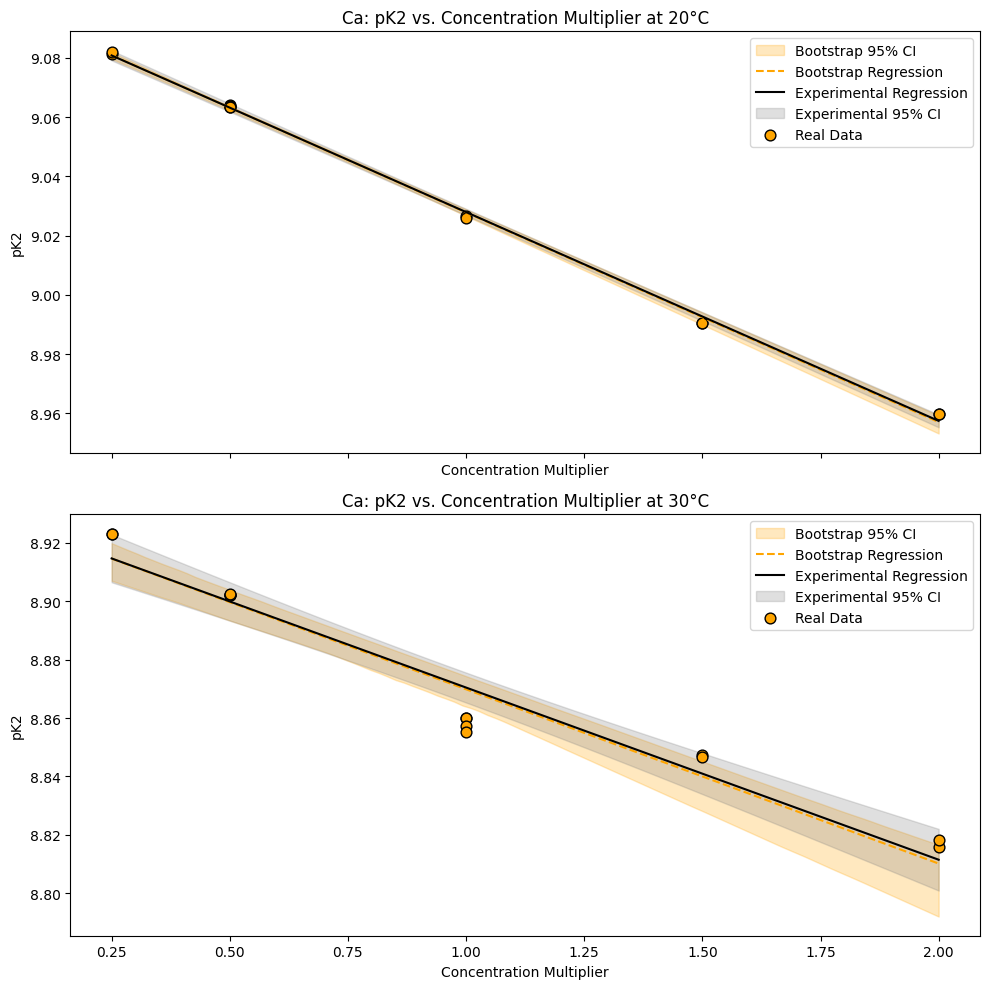

In [134]:


ion = 'Ca'
ion_data_all = filtered_data[filtered_data['Ion'] == ion]
unique_temperatures = sorted(ion_data_all['Temperature'].unique())

color = (1.0, 0.647, 0.0)  # RGB values for orange

fig, axs = plt.subplots(len(unique_temperatures), 1, figsize=(10, 5 * len(unique_temperatures)), sharex=True)
if len(unique_temperatures) == 1:
    axs = [axs]

for ax, temp in zip(axs, unique_temperatures):
    temp_data = ion_data_all[ion_data_all['Temperature'] == temp]
    X_raw = temp_data['Conc Multiplier'].values
    y_raw = temp_data['pK2'].values
    X_raw_2D = X_raw.reshape(-1, 1)

    conc_values = np.linspace(X_raw.min(), X_raw.max(), 100).reshape(-1, 1)

    # Bootstrap predictions
    n_bootstraps = 1000
    model = LinearRegression()
    boot_preds = []

    for _ in range(n_bootstraps):
        X_r, y_r = resample(X_raw_2D, y_raw)
        model.fit(X_r, y_r)
        boot_preds.append(model.predict(conc_values))

    boot_preds = np.array(boot_preds)
    boot_mean = np.mean(boot_preds, axis=0)
    lower_bound = np.percentile(boot_preds, 2.5, axis=0)
    upper_bound = np.percentile(boot_preds, 97.5, axis=0)

    # Experimental regression
    slope_exp, intercept_exp, r_value, p_value, stderr = linregress(X_raw, y_raw)
    y_fit_exp = intercept_exp + slope_exp * conc_values.flatten()

    # Experimental CI (95%)
    n = len(X_raw)
    dof = n - 2
    t_val = t.ppf(0.975, dof)
    x_mean = np.mean(X_raw)
    s_err = np.sqrt(np.sum((y_raw - (slope_exp * X_raw + intercept_exp))**2) / dof)

    se_fit = s_err * np.sqrt(
        1/n + (conc_values.flatten() - x_mean)**2 / np.sum((X_raw - x_mean)**2)
    )
    ci_upper_exp = y_fit_exp + t_val * se_fit
    ci_lower_exp = y_fit_exp - t_val * se_fit

    # Plot bootstrap CI
    ax.fill_between(
        conc_values.flatten(),
        lower_bound,
        upper_bound,
        color=color,
        alpha=0.25,
        label='Bootstrap 95% CI'
    )

    # Plot bootstrap regression
    ax.plot(
        conc_values,
        boot_mean,
        linestyle='--',
        color=color,
        label='Bootstrap Regression'
    )

    # Plot experimental regression line
    ax.plot(
        conc_values,
        y_fit_exp,
        linestyle='-',
        color='black',
        label='Experimental Regression'
    )

    # Plot experimental 95% CI band
    ax.fill_between(
        conc_values.flatten(),
        ci_lower_exp,
        ci_upper_exp,
        color='gray',
        alpha=0.25,
        label='Experimental 95% CI'
    )

    # Plot raw data
    ax.scatter(
        X_raw,
        y_raw,
        s=60,
        color=color,
        edgecolor='black',
        label='Real Data'
    )

    ax.set_title(f'{ion}: pK2 vs. Concentration Multiplier at {temp}°C')
    ax.set_xlabel('Concentration Multiplier')
    ax.set_ylabel('pK2')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()


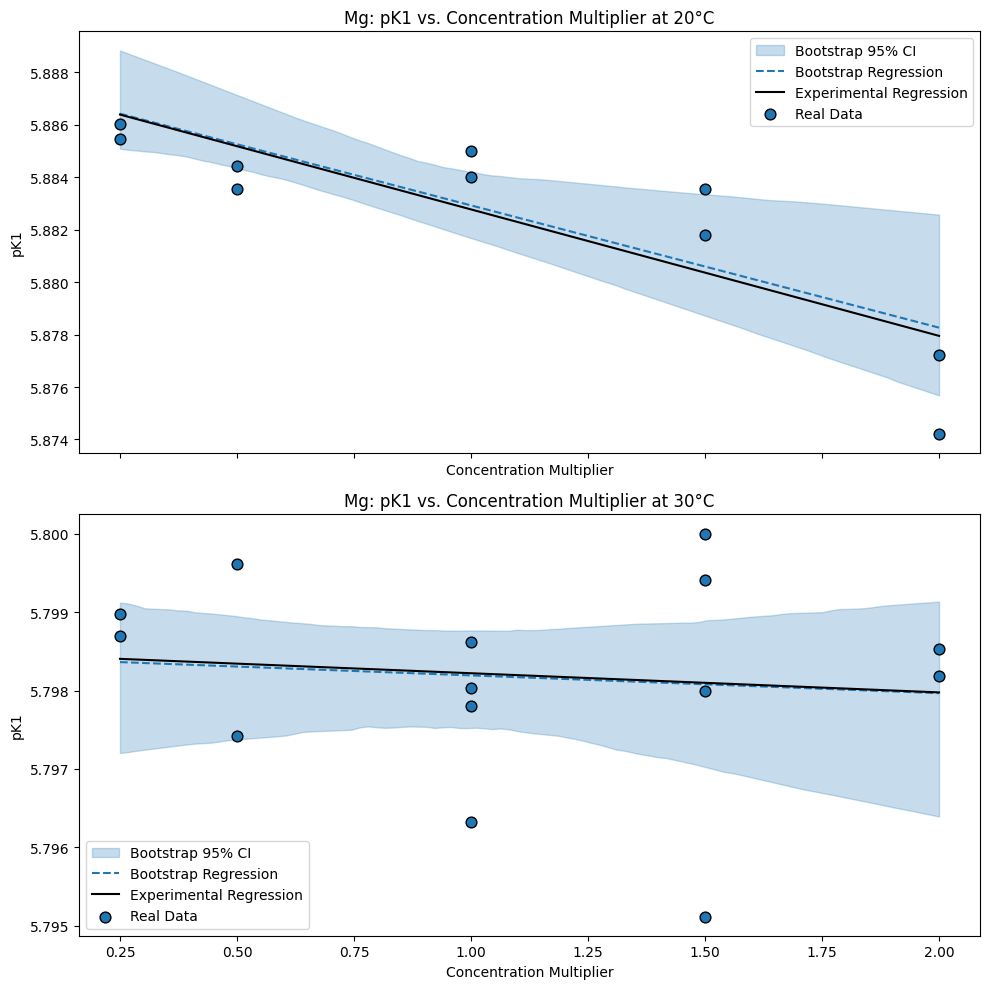

In [135]:

# Filter for Mg
ion = 'Mg'
ion_data_all = filtered_data[filtered_data['Ion'] == ion]
unique_temperatures = sorted(ion_data_all['Temperature'].unique())

# Color palette for Mg
color = sns.color_palette('tab10')[0]

# Plot per temperature
fig, axs = plt.subplots(len(unique_temperatures), 1, figsize=(10, 5 * len(unique_temperatures)), sharex=True)
if len(unique_temperatures) == 1:
    axs = [axs]

for ax, temp in zip(axs, unique_temperatures):
    temp_data = ion_data_all[ion_data_all['Temperature'] == temp]
    X_raw = temp_data['Conc Multiplier'].values
    y_raw = temp_data['pK1'].values
    X_raw_2D = X_raw.reshape(-1, 1)

    # Define a smooth x-axis for regression predictions
    conc_values = np.linspace(X_raw.min(), X_raw.max(), 100).reshape(-1, 1)

    # Bootstrap regression predictions
    n_bootstraps = 1000
    model = LinearRegression()
    boot_preds = []

    for _ in range(n_bootstraps):
        X_r, y_r = resample(X_raw_2D, y_raw)
        model.fit(X_r, y_r)
        boot_preds.append(model.predict(conc_values))

    boot_preds = np.array(boot_preds)
    boot_mean = np.mean(boot_preds, axis=0)
    lower_bound = np.percentile(boot_preds, 2.5, axis=0)
    upper_bound = np.percentile(boot_preds, 97.5, axis=0)

    # Experimental regression
    slope_exp, intercept_exp, _, _, _ = linregress(X_raw, y_raw)
    y_exp = intercept_exp + slope_exp * conc_values.flatten()

    # Plot Bootstrap CI
    ax.fill_between(
        conc_values.flatten(),
        lower_bound,
        upper_bound,
        color=color,
        alpha=0.25,
        label='Bootstrap 95% CI'
    )

    # Plot Bootstrap regression line
    ax.plot(
        conc_values,
        boot_mean,
        linestyle='--',
        color=color,
        label='Bootstrap Regression'
    )

    # Plot Experimental regression line
    ax.plot(
        conc_values,
        y_exp,
        linestyle='-',
        color='black',
        label='Experimental Regression'
    )

    # Plot raw data
    ax.scatter(
        X_raw,
        y_raw,
        s=60,
        color=color,
        edgecolor='black',
        label='Real Data'
    )

    ax.set_title(f'{ion}: pK1 vs. Concentration Multiplier at {temp}°C')
    ax.set_xlabel('Concentration Multiplier')
    ax.set_ylabel('pK1')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()


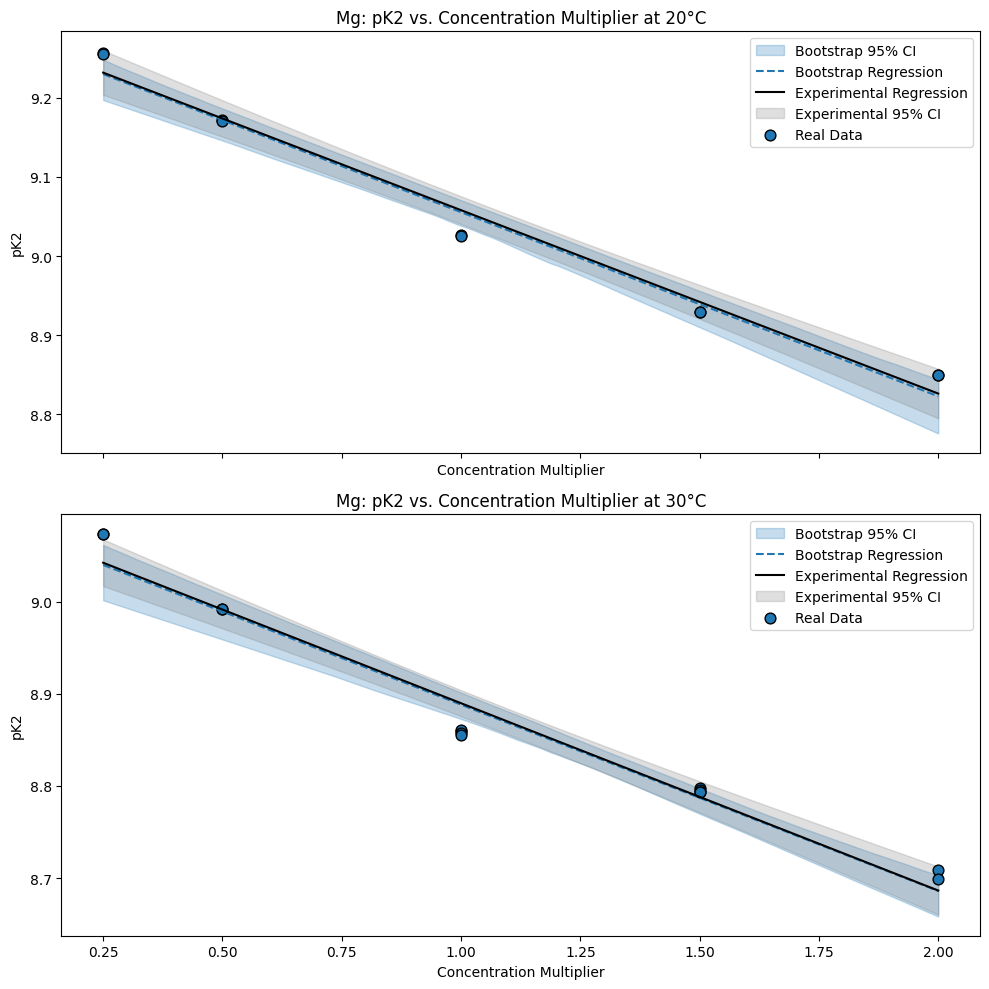

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from scipy.stats import linregress, t
import seaborn as sns

# Filter for Mg
ion = 'Mg'
ion_data_all = filtered_data[filtered_data['Ion'] == ion]
unique_temperatures = sorted(ion_data_all['Temperature'].unique())

color = sns.color_palette('tab10')[0]

fig, axs = plt.subplots(len(unique_temperatures), 1, figsize=(10, 5 * len(unique_temperatures)), sharex=True)
if len(unique_temperatures) == 1:
    axs = [axs]

for ax, temp in zip(axs, unique_temperatures):
    temp_data = ion_data_all[ion_data_all['Temperature'] == temp]
    X_raw = temp_data['Conc Multiplier'].values
    y_raw = temp_data['pK2'].values
    X_raw_2D = X_raw.reshape(-1, 1)

    conc_values = np.linspace(X_raw.min(), X_raw.max(), 100).reshape(-1, 1)

    # Bootstrap predictions
    n_bootstraps = 1000
    model = LinearRegression()
    boot_preds = []

    for _ in range(n_bootstraps):
        X_r, y_r = resample(X_raw_2D, y_raw)
        model.fit(X_r, y_r)
        boot_preds.append(model.predict(conc_values))

    boot_preds = np.array(boot_preds)
    boot_mean = np.mean(boot_preds, axis=0)
    lower_bound = np.percentile(boot_preds, 2.5, axis=0)
    upper_bound = np.percentile(boot_preds, 97.5, axis=0)

    # Experimental regression
    slope_exp, intercept_exp, r_value, p_value, stderr = linregress(X_raw, y_raw)
    y_fit_exp = intercept_exp + slope_exp * conc_values.flatten()

    # Experimental CI (95%)
    n = len(X_raw)
    dof = n - 2
    t_val = t.ppf(0.975, dof)
    x_mean = np.mean(X_raw)
    s_err = np.sqrt(np.sum((y_raw - (slope_exp * X_raw + intercept_exp))**2) / dof)

    se_fit = s_err * np.sqrt(
        1/n + (conc_values.flatten() - x_mean)**2 / np.sum((X_raw - x_mean)**2)
    )
    ci_upper_exp = y_fit_exp + t_val * se_fit
    ci_lower_exp = y_fit_exp - t_val * se_fit

    # Plot bootstrap CI
    ax.fill_between(
        conc_values.flatten(),
        lower_bound,
        upper_bound,
        color=color,
        alpha=0.25,
        label='Bootstrap 95% CI'
    )

    # Plot bootstrap regression
    ax.plot(
        conc_values,
        boot_mean,
        linestyle='--',
        color=color,
        label='Bootstrap Regression'
    )

    # Plot experimental regression line
    ax.plot(
        conc_values,
        y_fit_exp,
        linestyle='-',
        color='black',
        label='Experimental Regression'
    )

    # Plot experimental 95% CI band
    ax.fill_between(
        conc_values.flatten(),
        ci_lower_exp,
        ci_upper_exp,
        color='gray',
        alpha=0.25,
        label='Experimental 95% CI'
    )

    # Plot raw data
    ax.scatter(
        X_raw,
        y_raw,
        s=60,
        color=color,
        edgecolor='black',
        label='Real Data'
    )

    ax.set_title(f'{ion}: pK2 vs. Concentration Multiplier at {temp}°C')
    ax.set_xlabel('Concentration Multiplier')
    ax.set_ylabel('pK2')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()
